# Import Libraries and functions

In [4]:
# Import some libraries that will be used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

pd.set_option('display.max_columns', 300)

%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.ensemble import BaggingClassifier
import xgboost as xgb

import nltk
from nltk import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

import re
import string

import scipy
from textblob import TextBlob

from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alecmccabe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/alecmccabe/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/alecmccabe/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
from tqdm import tqdm
tqdm.pandas()

In [3]:
import gensim

ModuleNotFoundError: No module named 'gensim'

In [ ]:
from gensim.models import Word2Vec
wv = gensim.models.KeyedVectors.load_word2vec_format("/Users/alecmccabe/Desktop/Flatiron/Projects/final_project_ideas/GoogleNews-vectors-negative300.bin.gz", binary=True)
wv.init_sims(replace=True)

In [35]:
import gensim
import spacy

nlp = spacy.blank('en')

# Loop through range of all indexes, get words associated with each index.
# The words in the keys list will correspond to the order of the google embed matrix
keys = []
for idx in range(3000000):
    keys.append(wv.index2word[idx])

# Set the vectors for our nlp object to the google news vectors
nlp.vocab.vectors = spacy.vocab.Vectors(data=wv.syn0, keys=keys)

<ipython-input-35-5779fac04ac5>:13: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  nlp.vocab.vectors = spacy.vocab.Vectors(data=wv.syn0, keys=keys)


In [5]:
from nltk.stem import WordNetLemmatizer 
  
lemmatizer = WordNetLemmatizer()

In [6]:
#set stopwords and punctuations
stopwords = stopwords.words('english')
stopwords += list(string.punctuation)
stopwords += ["n't", "' '", "'re'","”","``","“","''","’","'s","'re","http","https","char",
              "reuters","wall","street","journal","photo","vice","news","like","time","make"]

In [7]:
def black_txt(token):
    return  token not in stopwords and token not in list(string.punctuation)  and len(token)>3

def clean_txt(text, string = True):
    clean_text = []
    clean_text2 = []
    text = text.lower()
    text = re.sub("'", "",text)
    text = re.sub("\n", "",text)
    text = re.sub("(\\d|\\W)+"," ",text)
    text = re.sub('time magazine','',text)
    text = re.sub('breitbart','',text)
    text = re.sub('click','',text)
    
    clean_text = [ lemmatizer.lemmatize(word, pos="v") for word in word_tokenize(text) if black_txt(word)]
    clean_text2 = [word for word in clean_text if black_txt(word)]
    
    if string == True:
        return " ".join(clean_text2)
    else:
        return clean_text2

# Load data

In [9]:
#load in data
data = pd.read_csv('clean_data2.csv', index_col = 0)

In [11]:
scaler = MinMaxScaler()
data[['polarity','mccphw','mscphw','coleman_index']] = scaler.fit_transform(data[['polarity','mccphw','mscphw','coleman_index']])


In [12]:
import pickle
# Save
with open('normalizer.pickle', 'wb') as f:
    pickle.dump(scaler, f)

In [13]:
data = pd.get_dummies(data,prefix='topic',columns=['dominant_topic'])

# Build Class Transformers, Pipeline

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction import DictVectorizer

In [15]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction import DictVectorizer
class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]

    
class TextStats(BaseEstimator, TransformerMixin):
    """Extract features from each document for DictVectorizer"""

    def fit(self, x, y=None):
        return self

    def transform(self, data):
        return [{'pol':  row['polarity'], 
                 'sub': row['subjectivity'],
                 'n_long_words': row['n_long_words'], 
                 'n_monosyllable_words': row['n_monosyllable_words'], 
                 'n_polysyllable_words': row['n_polysyllable_words'], 
                 'n_unique_words': row['n_unique_words'],
                 'coleman_index': row['coleman_index'], 
                 'mccphw': row['mccphw'],
                 'mscphw': row['mscphw'],
                 'profanity': row['profanity']} for _, row in data.iterrows()]

In [16]:
pipeline = Pipeline([
    ('union', FeatureUnion(
        transformer_list=[

            # Pipeline for pulling features from the text
            ('text', Pipeline([
                ('selector', ItemSelector(key='predictor')),
                ('tfidf', TfidfVectorizer( min_df =3, max_df=0.2, max_features=None, 
                    strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
                    ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
                    stop_words = None, preprocessor=clean_txt)),
            ])),

            # Pipeline for pulling metadata features
            ('stats', Pipeline([
                ('selector', ItemSelector(key=['polarity', 
                                               'subjectivity', 
                                              'n_long_words',
                                              'n_monosyllable_words',
                                              'n_polysyllable_words',
                                              'n_unique_words',
                                               'coleman_index',
                                               'mccphw',
                                               'mscphw',
                                               'profanity'])),
                ('stats', TextStats()),  # returns a list of dicts
                ('vect', DictVectorizer()),  # list of dicts -> feature matrix
            ])),

        ],

        # weight components in FeatureUnion
        transformer_weights={
            'text': 2,
            'stats': 1,
        },
    ))
])

**Create Column Names for later use**

In [17]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
seed = 40
X = data[['predictor', 'polarity', 'subjectivity','n_long_words','n_monosyllable_words',
         'n_polysyllable_words','n_unique_words','coleman_index','mccphw','mscphw','profanity']]

y = data['target']
# encoder = LabelEncoder()
# y = encoder.fit_transform(y)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

In [18]:
vectorizer = TfidfVectorizer( min_df =3, max_df=0.2, max_features=None, 
                    strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
                    ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
                    stop_words = None, preprocessor=clean_txt)

vectorizer.fit(x_train['predictor'])

TfidfVectorizer(max_df=0.2, min_df=3, ngram_range=(1, 3),
                preprocessor=<function clean_txt at 0x7fa10afd1040>,
                smooth_idf=1, strip_accents='unicode', sublinear_tf=1,
                token_pattern='\\w{1,}', use_idf=1)

In [19]:
vectorizer.transform(x_train['predictor'])

<12716x427096 sparse matrix of type '<class 'numpy.float64'>'
	with 4380307 stored elements in Compressed Sparse Row format>

In [20]:
columns = list(vectorizer.vocabulary_.keys())

In [21]:
for item in ['polarity', 'subjectivity','n_long_words','n_monosyllable_words',
         'n_polysyllable_words','n_unique_words','coleman_index','mccphw','mscphw','profanity']:
    columns.append(item)

In [22]:
pipeline.fit(x_train)

Pipeline(steps=[('union',
                 FeatureUnion(transformer_list=[('text',
                                                 Pipeline(steps=[('selector',
                                                                  ItemSelector(key='predictor')),
                                                                 ('tfidf',
                                                                  TfidfVectorizer(max_df=0.2,
                                                                                  min_df=3,
                                                                                  ngram_range=(1,
                                                                                               3),
                                                                                  preprocessor=<function clean_txt at 0x7fa10afd1040>,
                                                                                  smooth_idf=1,
                                                    

In [23]:
import pickle
with open('pipeline.pickle', 'wb') as f:
    pickle.dump(pipeline, f)

In [24]:
%%time
train_vec = pipeline.transform(x_train)
test_vec = pipeline.transform(x_test)
print("Checking that the number of features in train and test correspond: %s - %s" % (train_vec.shape, test_vec.shape))

Checking that the number of features in train and test correspond: (12716, 427106) - (3179, 427106)
CPU times: user 1min 44s, sys: 300 ms, total: 1min 44s
Wall time: 1min 45s


# tSNE Analysis

In [20]:
from sklearn.manifold import TSNE

In [21]:
tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(train_vec)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 12716 samples in 0.031s...
[t-SNE] Computed neighbors for 12716 samples in 14.332s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12716
[t-SNE] Computed conditional probabilities for sample 2000 / 12716
[t-SNE] Computed conditional probabilities for sample 3000 / 12716
[t-SNE] Computed conditional probabilities for sample 4000 / 12716
[t-SNE] Computed conditional probabilities for sample 5000 / 12716
[t-SNE] Computed conditional probabilities for sample 6000 / 12716
[t-SNE] Computed conditional probabilities for sample 7000 / 12716
[t-SNE] Computed conditional probabilities for sample 8000 / 12716
[t-SNE] Computed conditional probabilities for sample 9000 / 12716
[t-SNE] Computed conditional probabilities for sample 10000 / 12716
[t-SNE] Computed conditional probabilities for sample 11000 / 12716
[t-SNE] Computed conditional probabilities for sample 12000 / 12716
[t-SNE] Computed conditional probabilities for s

In [22]:
placeholder = {}
placeholder['one'] = tsne_results[:,0]
placeholder['two'] = tsne_results[:,1]
placeholder['three'] = tsne_results[:,2]
placeholder_df = pd.DataFrame(placeholder)

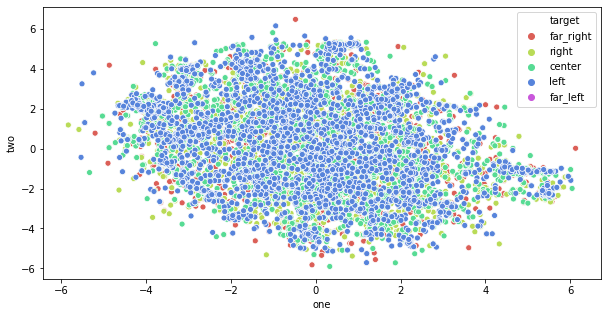

In [23]:
plt.figure(figsize=(10,5))
sns.scatterplot(
    x="one", y="two",
    hue=y_train,
    palette=sns.color_palette("hls", 5),
    data=placeholder_df,
    legend="full")

plt.savefig('/Users/alecmccabe/Desktop/Flatiron/Projects/final_project_ideas/web_articles_spin/Pics/tSNE.png')
plt.show()

# Test different models

In [25]:
from sklearn.metrics import plot_confusion_matrix

In [26]:
results = pd.DataFrame(columns = ['model','accuracy'])
results

,model,accuracy


In [27]:
new_row = {'model': 'Dummy', 'accuracy': .291961}
results = results.append(new_row, ignore_index=True)
results

,model,accuracy
0,Dummy,0.291961


------------

In [58]:
from sklearn.calibration import CalibratedClassifierCV

In [59]:
#Linear Support Vector Machines
lin_svc = LinearSVC(C=1, class_weight='balanced', multi_class='ovr', random_state=40,verbose=3) 
svc_cal = CalibratedClassifierCV(lin_svc) 

svc_cal.fit(train_vec, y_train)
test_preds = svc_cal.predict(test_vec)

accuracy = accuracy_score(y_test, test_preds)

new_row = {'model': 'SVM', 'accuracy': accuracy}
results = results.append(new_row, ignore_index=True)
results

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

,model,accuracy
0,Dummy,0.291961
1,SVM,0.892104


In [27]:
with open('model.pickle', 'wb') as f:
    pickle.dump(svc_cal, f)

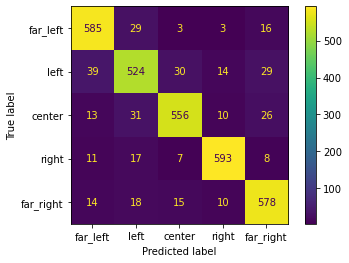

In [60]:
plot_confusion_matrix(svc_cal,test_vec,y_test, labels=['far_left','left','center','right','far_right'])
plt.savefig('/Users/alecmccabe/Desktop/Flatiron/Projects/final_project_ideas/web_articles_spin/Pics/svm_confusion.png')


------------

In [61]:
#Random Forest - best so far is 500 trees with sqrt max features
rfc_clf = RandomForestClassifier(n_estimators=200,max_features='sqrt',random_state=0,n_jobs=-1,verbose=1)
rfc_clf.fit(train_vec, y_train)
test_preds = rfc_clf.predict(test_vec)

accuracy = accuracy_score(y_test, test_preds)

new_row = {'model': 'RFC', 'accuracy': accuracy}
results = results.append(new_row, ignore_index=True)
results

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   27.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.7s finished


,model,accuracy
0,Dummy,0.291961
1,SVM,0.892104
2,RFC,0.829192


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.7s finished


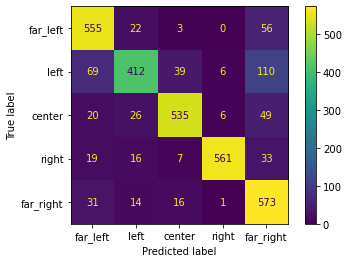

In [62]:
plot_confusion_matrix(rfc_clf,test_vec,y_test, labels=['far_left','left','center','right','far_right'])

------------

In [63]:
#Multinomial Bayes
mnb_lemma = MultinomialNB(alpha = 0.0000001)
mnb_lemma.fit(train_vec, y_train)
test_preds = mnb_lemma.predict(test_vec)

accuracy = accuracy_score(y_test, test_preds)

new_row = {'model': 'MNB', 'accuracy': accuracy}
results = results.append(new_row, ignore_index=True)
results

,model,accuracy
0,Dummy,0.291961
1,SVM,0.892104
2,RFC,0.829192
3,MNB,0.772570


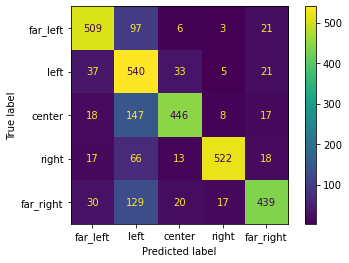

In [64]:
plot_confusion_matrix(mnb_lemma,test_vec,y_test, labels=['far_left','left','center','right','far_right'])

----------

In [65]:
#Passive Aggressive Classifier
pac = PassiveAggressiveClassifier(C = 5, random_state=0, n_jobs=-1)

pac.fit(train_vec, y_train)
test_preds = pac.predict(test_vec)

accuracy = accuracy_score(y_test, test_preds)

new_row = {'model': 'PAC', 'accuracy': accuracy}
results = results.append(new_row, ignore_index=True)
results

,model,accuracy
0,Dummy,0.291961
1,SVM,0.892104
2,RFC,0.829192
3,MNB,0.772570
4,PAC,0.893363


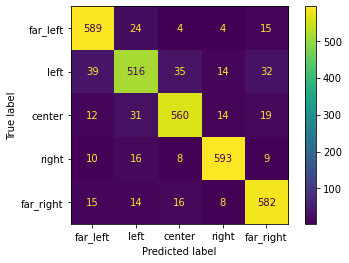

In [66]:
plot_confusion_matrix(pac,test_vec,y_test,labels=['far_left','left','center','right','far_right'])

-----

In [67]:
#bagging classifier
bc_lr = BaggingClassifier(
            base_estimator=LinearSVC(C=1, class_weight='balanced', multi_class='ovr', random_state=40,verbose=3))

bc_lr.fit(train_vec, y_train)
test_preds = bc_lr.predict(test_vec)

accuracy = accuracy_score(y_test, test_preds)

new_row = {'model': 'Bag', 'accuracy': accuracy}
results = results.append(new_row, ignore_index=True)
results


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

,model,accuracy
0,Dummy,0.291961
1,SVM,0.892104
2,RFC,0.829192
3,MNB,0.772570
4,PAC,0.893363
5,Bag,0.881409


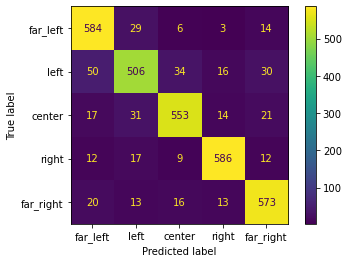

In [68]:
plot_confusion_matrix(bc_lr,test_vec,y_test,labels=['far_left','left','center','right','far_right'])

-----

In [33]:
le = LabelEncoder()
y_train_encode = le.fit_transform(y_train)

In [34]:
y_test_encode = le.transform(y_test)

In [45]:
le.inverse_transform(y_test_encode)

array(['left', 'right', 'far_right', ..., 'center', 'left', 'center'],
      dtype=object)

In [52]:
le.inverse_transform(np.array([3]))

array(['left'], dtype=object)

In [53]:
with open('encoder.pickle', 'wb') as f:
    pickle.dump(le, f)

In [35]:
#XGBoost
xg_clf = xgb.XGBClassifier(objective ='multi:softmax', 
                           booster='gbtree',
                           colsample_bytree = .1,
                           random_state=0,
                          n_estimators=1000,
                          n_jobs=-1)

xg_clf.fit(train_vec, y_train_encode)
test_preds = xg_clf.predict(test_vec)

accuracy = accuracy_score(y_test_encode, test_preds)

In [36]:
accuracy

0.897137464611513

In [37]:
new_row = {'model': 'XGB', 'accuracy': accuracy}
results = results.append(new_row, ignore_index=True)
results

,model,accuracy
0,Dummy,0.291961
1,XGB,0.897137


In [38]:
with open('model.pickle', 'wb') as f:
    pickle.dump(xg_clf, f)

In [73]:
feature_importance = pd.DataFrame(sorted(list(zip(columns, xg_clf.feature_importances_)),key=lambda x: x[1], reverse=True),
             columns=['feature','importance'])
top100words = list(feature_importance['feature'][0:100])
top100scores = list(feature_importance['importance'][0:100])

In [74]:
from wordcloud import WordCloud
dictionary = dict(zip(top100words, top100scores))

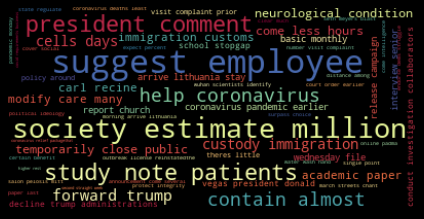

In [75]:
# Create the word cloud:

wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(dictionary)

# Display the generated image w/ matplotlib:

plt.figure(figsize=(6,6), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)

# Uncomment the next line if you want to save your image:
plt.tight_layout()
plt.savefig('/Users/alecmccabe/Desktop/Flatiron/Projects/final_project_ideas/web_articles_spin/Pics/xgb_features.png')

plt.show()

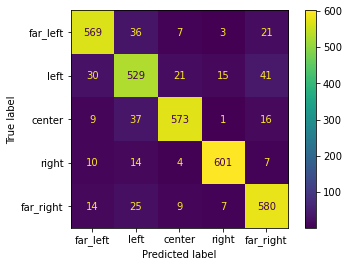

In [76]:
plot_confusion_matrix(xg_clf,test_vec,y_test, labels=['far_left','left','center','right','far_right'])
plt.savefig('/Users/alecmccabe/Desktop/Flatiron/Projects/final_project_ideas/web_articles_spin/Pics/xgb_confusion.png')


In [14]:
import pickle
pipeline = pd.read_pickle('/Users/alecmccabe/Desktop/Flatiron/Projects/final_project_ideas/web_articles_spin/scripts/pipeline.pickle')
model = pd.read_pickle('/Users/alecmccabe/Desktop/Flatiron/Projects/final_project_ideas/web_articles_spin/scripts/model.pickle')


In [15]:
x_transform = pipeline.transform(x_test)
test_preds = model.predict(x_transform)

accuracy = accuracy_score(y_test, test_preds)

In [58]:
eval_df = pd.concat([x_test,y_test],axis=1)
eval_df['estimate'] = test_preds

In [59]:
eval_df.reset_index(drop=True,inplace=True)

In [60]:
class_map = {'far_left':0,
            'left':1,
            'center':2,
            'right':3,
            'far_right':4}

In [61]:
eval_df['target_num'] = eval_df['target'].map(class_map)
eval_df['estimate_num'] = eval_df['estimate'].map(class_map)

In [62]:
eval_df['target-guess'] = eval_df['target'] + " " + eval_df['estimate']

In [63]:
eval_df['degree'] = abs(eval_df['target_num'] - eval_df['estimate_num'])

In [64]:
incorrect = eval_df[eval_df['degree']!=0]

In [65]:
incorrect

,predictor,polarity,subjectivity,n_long_words,n_monosyllable_words,n_polysyllable_words,n_unique_words,coleman_index,mccphw,mscphw,profanity,target,estimate,target_num,estimate_num,target-guess,degree
10,"Colds and Flus, the Unintended but Appreciated...",0.697296,0.388276,0.256716,0.635821,0.170149,0.585075,0.725801,0.207901,0.257384,0.000000,far_right,center,4,2,far_right center,2
15,"Texas begins voting, amid coronavirus resurgen...",0.726635,0.446062,0.235602,0.695026,0.103403,0.534031,0.713505,0.161058,0.261885,0.005807,right,center,3,2,right center,1
20,I had to go to 3 different urgent care clinics...,0.698864,0.502903,0.129787,0.795745,0.057447,0.472340,0.726328,0.040658,0.230380,0.000000,left,far_left,1,0,left far_left,1
25,Plane Forced to Make Early Landing in Japan Af...,0.575666,0.305049,0.244565,0.676630,0.122283,0.510870,0.792677,0.111111,0.177215,0.002481,far_left,left,0,1,far_left left,1
29,Widespread Vote-by-Mail Could Delay Michigan P...,0.641584,0.399795,0.282794,0.618399,0.147359,0.414821,0.798084,0.200943,0.186204,0.004717,far_right,left,4,1,far_right left,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3151,It’s Official: Jamaal Bowman Has Defeated Elio...,0.710822,0.445979,0.275578,0.627063,0.143564,0.572607,0.815905,0.191111,0.167370,0.012103,far_left,left,0,1,far_left left,1
3158,Twitter temporarily limits Donald Trump Jr.'s ...,0.627389,0.308547,0.323601,0.625304,0.153285,0.445255,0.620451,0.268995,0.369198,0.000000,left,far_left,1,0,left far_left,1
3163,"World’s Wrongest Man, Larry Kudlow, Calls Trum...",0.525868,0.571889,0.265372,0.640777,0.148867,0.605178,0.673636,0.190519,0.305204,0.000000,far_left,far_right,0,4,far_left far_right,4
3174,Report: Capital County in Pennsylvania Backs D...,0.543060,0.290000,0.297483,0.615561,0.178490,0.530892,0.791729,0.208889,0.193624,0.003992,far_right,left,4,1,far_right left,3


In [77]:
chart_data = pd.DataFrame(incorrect.groupby(by=['target-guess']).count()['estimate']).sort_values(by='estimate',ascending=False)


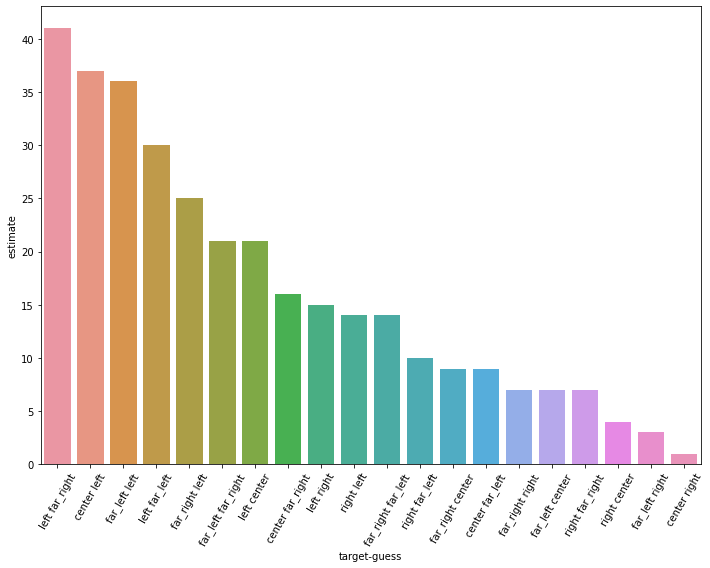

In [83]:
plt.figure(figsize=(10,8))
ax = sns.barplot(x=chart_data.index, y=chart_data.estimate, data=chart_data)
l = ax.set_xticklabels(ax.get_xticklabels(), rotation=60)
plt.tight_layout()
plt.savefig('/Users/alecmccabe/Desktop/Flatiron/Projects/final_project_ideas/web_articles_spin/Pics/incorrects.png')
plt.show()

In [80]:
chart2_data = pd.DataFrame(incorrect.groupby(by=['degree']).count()['estimate']).sort_values(by='estimate', ascending=False)


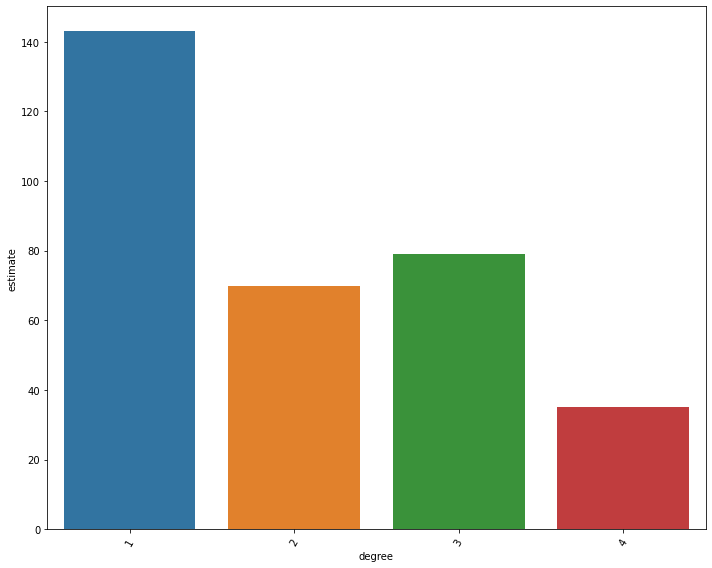

In [82]:
plt.figure(figsize=(10,8))
ax = sns.barplot(x=chart2_data.index, y=chart2_data.estimate, data=chart2_data)
l = ax.set_xticklabels(ax.get_xticklabels(), rotation=60)
plt.tight_layout()
plt.savefig('/Users/alecmccabe/Desktop/Flatiron/Projects/final_project_ideas/web_articles_spin/Pics/incorrects2.png')
plt.show()

In [85]:
(143+70)/(chart2_data.sum())

estimate    0.651376
dtype: float64

In [86]:
chart2_data.sum()

estimate    327
dtype: int64

In [58]:
incorrect[incorrect['target-guess']=='left far_right']

,predictor,polarity,subjectivity,n_long_words,n_monosyllable_words,n_polysyllable_words,n_unique_words,coleman_index,mccphw,mscphw,profanity,target,estimate,result,target-guess
233,"Man United's revenue drops, debts rise amid pa...",0.480967,0.331602,0.231250,0.712500,0.075000,0.581250,0.735297,0.132840,0.236287,0.000000,left,far_right,incorrect,left far_right
333,Standard Liege hope to take inspiration from r...,0.696104,0.328977,0.234536,0.721649,0.087629,0.536082,0.753343,0.150053,0.221519,0.002404,left,far_right,incorrect,left far_right
433,Miami’s Republican mayor won’t commit to votin...,0.545193,0.365622,0.263158,0.642659,0.191136,0.590028,0.687918,0.189136,0.291139,0.012225,left,far_right,incorrect,left far_right
438,First lady sends gifts to hospitals dealing wi...,0.635069,0.241711,0.297030,0.648515,0.148515,0.549505,0.747240,0.205926,0.236287,0.004202,left,far_right,incorrect,left far_right
516,Chuck Woolery says 'everyone is lying' about c...,0.641246,0.491763,0.260163,0.682927,0.121951,0.556911,0.625298,0.168148,0.348523,0.020067,left,far_right,incorrect,left far_right
543,Trump says it could take 'months' or 'years' t...,0.564314,0.472237,0.225389,0.709845,0.101036,0.525907,0.725713,0.167407,0.251055,0.002283,left,far_right,incorrect,left far_right
583,"In crisis, Tom Hanks is more of a role model t...",0.772643,0.496605,0.247458,0.667797,0.149153,0.630508,0.607186,0.156741,0.364276,0.006154,left,far_right,incorrect,left far_right
636,Andy Murray wants assurances over coronavirus ...,0.675048,0.375715,0.182039,0.733010,0.097087,0.533981,0.694003,0.159788,0.280591,0.000000,left,far_right,incorrect,left far_right
659,The Middle East is on the cusp of a new era. R...,0.594805,0.393301,0.238267,0.671480,0.122744,0.492178,0.763274,0.161481,0.213701,0.010616,left,far_right,incorrect,left far_right
802,"Watchmen, Maisel, Ozark lead diverse lineup fo...",0.739336,0.429821,0.228106,0.639511,0.130346,0.553971,0.810121,0.180576,0.171308,0.019400,left,far_right,incorrect,left far_right


In [54]:
left_to_far_right = list(incorrect[incorrect['target-guess']=='left far_right']['predictor'])

In [55]:
for item in left_to_far_right:
    print(item)
    print("")
    print('------------')

Man United's revenue drops, debts rise amid pandemic Manchester United's revenue dropped by almost a fifth because the team did not play in the Champions League and because it was forced to close its stadium to fans during the coronavirus pandemic, the English club said Wednesday.

The Premier League club, which is listed on the New York Stock Exchange, generated 509 million pounds ($665 million) in the year to June 30 — a drop of 19%. Debt soared 133% to 474.1 million pounds ($619 million), while there was a loss of 23.2 million pounds ($30 million).

While the team is back in the Champions League, there is no return of matchday revenue from supporters with games still being played in empty stadiums to contain the spread of the coronavirus.

United made only 5.5 million pounds ($7 million) in matchday revenue from April to June, compared to 23.8 million pounds ($31 million) the previous year.

___

------------
Standard Liege hope to take inspiration from rivals against Rangers after 

--------

**Test out Word2Vec**

In [77]:
class SpacyVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, nlp):
        self.nlp = nlp
        self.dim = 300

    def fit(self, X, y):
        return self

    def transform(self, X):
        # Doc.vector defaults to an average of the token vectors.
        # https://spacy.io/api/doc#vector
        
        return [self.nlp(text).vector for text in X]

In [78]:
X = data['predictor']
y =data['target']
encoder = LabelEncoder()
y = encoder.fit_transform(y)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

In [79]:
embeddings_pipeline = Pipeline(
    steps=[
        ("mean_embeddings", SpacyVectorTransformer(nlp)),
        ("reduce_dim", TruncatedSVD(50)),
        ("classifier", PassiveAggressiveClassifier(C=5,random_state=0,n_jobs=-1, verbose=1)),
    ]
)
embeddings_pipeline.fit(x_train, y_train)
y_pred = embeddings_pipeline.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)

new_row = {'model': 'word2vec', 'accuracy': accuracy}
results = results.append(new_row, ignore_index=True)
results


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


-- Epoch 1-- Epoch 1

-- Epoch 1-- Epoch 1-- Epoch 1


Norm: 155.88, NNZs: 50, Bias: 0.969566, T: 12716, Avg. loss: 0.824936
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 105.47, NNZs: 50, Bias: 3.492205, T: 12716, Avg. loss: 1.099681
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 122.49, NNZs: 50, Bias: 2.183176, T: 12716, Avg. loss: 0.996430
Norm: 113.47, NNZs: 50, Bias: -1.122982, T: 12716, Avg. loss: 1.111239Total training time: 0.00 seconds.
Total training time: 0.00 seconds.
-- Epoch 2

-- Epoch 2
Norm: 94.16, NNZs: 50, Bias: -14.112310, T: 12716, Avg. loss: 1.128198
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 207.98, NNZs: 50, Bias: -1.685547, T: 25432, Avg. loss: 0.555548
Total training time: 0.01 seconds.
-- Epoch 3
Norm: 150.79, NNZs: 50, Bias: -0.932202, T: 25432, Avg. loss: 1.039951
Total training time: 0.01 seconds.
-- Epoch 3
Norm: 177.32, NNZs: 50, Bias: 0.851492, T: 25432, Avg. loss: 1.005900Norm: 169.46, NNZs: 50, Bias: 1.209229, T: 25432, Avg. loss:

,model,accuracy
0,Dummy,0.291961
1,SVM,0.892104
2,RFC,0.829192
3,MNB,0.772570
4,PAC,0.893363
5,Bag,0.881409
6,XGB,0.897137
7,word2vec,0.452029


-----

**Deep Learning, Spacy**

In [80]:
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM, Embedding
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils
from keras.layers import Dense, Input, LSTM, Bidirectional, Activation, Conv1D, GRU, TimeDistributed
from keras.layers import Dropout, Embedding, GlobalMaxPooling1D, MaxPooling1D, Add, Flatten, SpatialDropout1D
from keras.layers import GlobalAveragePooling1D, BatchNormalization, concatenate
from keras.layers import Reshape, merge, Concatenate, Lambda, Average
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints

In [81]:
from sklearn.model_selection import train_test_split
import time
X = data['predictor']
y =data['target']
encoder = LabelEncoder()
y = encoder.fit_transform(y)
Y = np_utils.to_categorical(y)
##Create the tf-idf vector
vectorizer = TfidfVectorizer( min_df =3, max_df=0.2, max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = None, preprocessor=clean_txt)

In [82]:
seed = 40
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=seed, stratify =y)
vectorizer.fit(x_train)

TfidfVectorizer(max_df=0.2, min_df=3,
                preprocessor=<function clean_txt at 0x12b5ef0d0>, smooth_idf=1,
                strip_accents='unicode', sublinear_tf=1,
                token_pattern='\\w{1,}', use_idf=1)

In [83]:
word2idx = {word: idx for idx, word in enumerate(vectorizer.get_feature_names())}
tokenize = vectorizer.build_tokenizer()
preprocess = vectorizer.build_preprocessor()
 
def to_sequence(tokenizer, preprocessor, index, text):
    words = tokenizer(preprocessor(text))
    indexes = [index[word] for word in words if word in index]
    return indexes

X_train_sequences = [to_sequence(tokenize, preprocess, word2idx, x) for x in x_train]
print(X_train_sequences[0])

[24873, 4355, 987, 18881, 4335, 1520, 10099, 24874, 16012, 14033, 4355, 1660, 15741, 3168, 14033, 10828, 17184, 19028, 15663, 17477, 11750, 9090, 21866, 9035, 21684, 14033, 2682, 1742, 7051, 25082, 3384, 11867, 10871, 22343, 3668, 24873, 24874, 16012, 14033, 1842, 1520, 4335, 987, 10099, 2258, 18881, 18697, 3664, 21643, 13337, 1842, 8979, 14033, 10828, 16969, 2775, 17184, 19028, 15663, 2627, 5977, 15741, 3168, 23174, 11292, 8832, 2798, 824, 1744, 19920, 7911, 16027, 25079, 9728, 4612, 14033, 11972, 5461, 2682, 1742, 315, 15840, 4640, 6372, 12157, 24418, 9329, 4817, 12155, 6169, 18881, 14033, 18097, 14696, 8832, 25010, 5308, 10099, 22843, 18400, 956, 5998, 22651, 1742, 2258, 15796, 24876, 17979, 4339, 20790, 9035, 1520, 12885, 7486, 16728, 1749, 13178, 4335, 1520, 11226, 13910, 2457, 9090, 21866, 9035, 21684, 8935, 2182, 10005, 2431, 12544, 7348, 15115, 11971, 6500, 14033, 13529, 24873, 4355, 19722, 16582, 20963, 12182, 581, 14958, 824, 15115, 24873, 16582, 9653, 3664, 14033, 24873, 615

In [89]:
# Compute the max lenght of a text

MAX_SEQ_LENGHT=200

N_FEATURES = len(vectorizer.get_feature_names())
X_train_sequences = pad_sequences(X_train_sequences, maxlen=MAX_SEQ_LENGHT, value=N_FEATURES)
print(X_train_sequences[0])

[19631  1660  4716  7766  8099  8098 13488  1749  6500  4611 16088 19810
 16034 15415   961 10544 23291 24308 13743 15912 10544  6801 24873 13357
 18015  3664  9278 14615 10544 12544 15663 23564 19018  1820 23286 19018
   647 24874 16606 13337 12584 10125 16900 14033 10125  6372 16606 13337
 16214 22652 18881 10125 15912  9322   647  9090 10005  2431 18709   656
 24251 16582  8738 24935  4751  2457   356  2798  3713  4516 24873  2798
 11798  4974 24874 15771  7350 22651  5932  9316 16566 13182 20327 25201
  2798  3713 12236  1564  7637  9316  8322 24874 11292 20996 24385 10319
 18474 24976  4458  1842 10329 21151 10319 11226 10136  3658  1200 17142
  2150 19861 14033  4703 19124 10068 24873 14033   857  1765  9537 23053
 25619 23661 23369  1520 22781  1749  1742 11116 16728  3188 22118  4670
 24934  4355 16667  6026 18881  4640 16582 19122 10125  4641  9887 16606
 17889  1842 22151 22602 14034   857  8357  1628  7186  1756  1912  5452
 18366 23169  7348  8738 11716 24874 23260 22065 15

In [90]:
X_test_sequences = [to_sequence(tokenize, preprocess, word2idx, x) for x in x_test]
X_test_sequences = pad_sequences(X_test_sequences, maxlen=MAX_SEQ_LENGHT, value=N_FEATURES)

In [91]:
EMBEDDINGS_LEN = 300

embeddings_index = np.zeros((len(vectorizer.get_feature_names()) + 1, EMBEDDINGS_LEN))
for word, idx in word2idx.items():
    try:
        embedding = nlp.vocab[word].vector
        embeddings_index[idx] = embedding
    except:
        pass
      
print("EMBEDDINGS_LEN=", EMBEDDINGS_LEN)

EMBEDDINGS_LEN= 300


In [92]:
model = Sequential()
model.add(Embedding(len(vectorizer.get_feature_names()) + 1,
                    EMBEDDINGS_LEN,  # Embedding size
                    weights=[embeddings_index],
                    input_length=MAX_SEQ_LENGHT,
                    trainable=False))
model.add(LSTM(300, dropout=0.2))
model.add(Dense(len(set(y)), activation='softmax'))
 
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 300)          7824900   
_________________________________________________________________
lstm_1 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1505      
Total params: 8,547,605
Trainable params: 722,705
Non-trainable params: 7,824,900
_________________________________________________________________
None


In [93]:
model.fit(X_train_sequences, y_train, 
          epochs=5, batch_size=128, verbose=1, 
          validation_split=0.1)
 
scores = model.evaluate(X_test_sequences, y_test, verbose=1)
print("Accuracy:", scores[1])


Epoch 1/5
90/90 [==============================] - 78s 871ms/step - loss: 1.4785 - accuracy: 0.3925 - val_loss: 1.3765 - val_accuracy: 0.4347
Epoch 2/5
90/90 [==============================] - 80s 887ms/step - loss: 1.3196 - accuracy: 0.4601 - val_loss: 1.2797 - val_accuracy: 0.4811
Epoch 3/5
90/90 [==============================] - 85s 948ms/step - loss: 1.2409 - accuracy: 0.4999 - val_loss: 1.2562 - val_accuracy: 0.4819
Epoch 4/5
90/90 [==============================] - 84s 936ms/step - loss: 1.1938 - accuracy: 0.5223 - val_loss: 1.2098 - val_accuracy: 0.5008
Epoch 5/5
100/100 [==============================] - 18s 176ms/step - loss: 1.0861 - accuracy: 0.5602
Accuracy: 0.5602390766143799


In [94]:
accuracy = scores[1]

new_row = {'model': 'LSTM-Simple', 'accuracy': accuracy}
results = results.append(new_row, ignore_index=True)
results

,model,accuracy
0,Dummy,0.291961
1,SVM,0.892104
2,RFC,0.829192
3,MNB,0.772570
4,PAC,0.893363
5,Bag,0.881409
6,XGB,0.897137
7,word2vec,0.452029
8,LSTM-Simple,0.560239


------

**LSTM with new features**

In [95]:
from keras.models import Model
from keras.layers import Dense ,LSTM,concatenate,Input,Flatten,BatchNormalization, GRU

text_data = Input(shape=(MAX_SEQ_LENGHT,), name='text')
meta_data = Input(shape=(10,), name = 'meta')
x=(Embedding(len(vectorizer.get_feature_names()) + 1,
                    EMBEDDINGS_LEN,  # Embedding size
                    weights=[embeddings_index],
                    input_length=MAX_SEQ_LENGHT,
                    trainable=False))(text_data)
x2 = ((LSTM(300, dropout=0.2, recurrent_dropout=0.2)))(x)
x4 = concatenate([x2, meta_data])
x5 = Dense(150, activation='relu')(x4)
x6 = Dropout(0.25)(x5)
x7 = BatchNormalization()(x6)
out=(Dense(len(set(y)), activation="softmax"))(x7)
model = Model(inputs=[text_data, meta_data ], outputs=out)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 200, 300)     7824900     text[0][0]                       
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 300)          721200      embedding_2[0][0]                
__________________________________________________________________________________________________
meta (InputLayer)               [(None, 10)]         0                                            
_______________________________________________________________________________________

In [96]:
df_cat_train = data.iloc[x_train.index][['polarity', 'subjectivity', 'topic_0',
                                        'topic_1',
                                        'topic_2',
                                        'topic_3',
                                        'topic_4',
                                        'topic_5',
                                        'topic_6',
                                        'topic_7']]
df_cat_test = data.iloc[x_test.index][['polarity', 'subjectivity', 'topic_0',
                                        'topic_1',
                                        'topic_2',
                                        'topic_3',
                                        'topic_4',
                                        'topic_5',
                                        'topic_6',
                                        'topic_7']]

In [97]:
model.fit([X_train_sequences, df_cat_train], y_train, 
          epochs=12, batch_size=128, verbose=1, 
          validation_split=0.1)
 
scores = model.evaluate([X_test_sequences, df_cat_test],y_test, verbose=1)
print("Accuracy:", scores[1])  

Epoch 1/12
90/90 [==============================] - 138s 2s/step - loss: 1.4283 - accuracy: 0.4196 - val_loss: 1.5469 - val_accuracy: 0.3585
Epoch 2/12
90/90 [==============================] - 135s 2s/step - loss: 1.2153 - accuracy: 0.5131 - val_loss: 1.4903 - val_accuracy: 0.3742
Epoch 3/12
90/90 [==============================] - 147s 2s/step - loss: 1.1117 - accuracy: 0.5585 - val_loss: 1.4006 - val_accuracy: 0.4465
Epoch 4/12
90/90 [==============================] - 141s 2s/step - loss: 1.0536 - accuracy: 0.5841 - val_loss: 1.3222 - val_accuracy: 0.5314
Epoch 5/12
90/90 [==============================] - 143s 2s/step - loss: 0.9905 - accuracy: 0.6151 - val_loss: 1.2054 - val_accuracy: 0.5511
Epoch 6/12
90/90 [==============================] - 144s 2s/step - loss: 0.9430 - accuracy: 0.6328 - val_loss: 1.1482 - val_accuracy: 0.5519
Epoch 7/12
90/90 [==============================] - 157s 2s/step - loss: 0.8840 - accuracy: 0.6624 - val_loss: 1.2011 - val_accuracy: 0.5369
Epoch 8/12
90

In [98]:
accuracy = scores[1]

new_row = {'model': 'LSTM-MetaFeatures', 'accuracy': accuracy}
results = results.append(new_row, ignore_index=True)
results

,model,accuracy
0,Dummy,0.291961
1,SVM,0.892104
2,RFC,0.829192
3,MNB,0.772570
4,PAC,0.893363
5,Bag,0.881409
6,XGB,0.897137
7,word2vec,0.452029
8,LSTM-Simple,0.560239
9,LSTM-MetaFeatures,0.642655


In [99]:
results = results.sort_values(by='accuracy', ascending=True)
results.reset_index(drop=True, inplace=True)

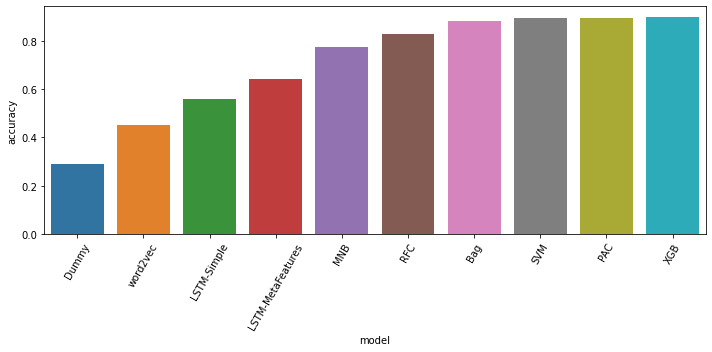

In [100]:
plt.figure(figsize=(10,5))
ax = sns.barplot(x=results.model, y=results.accuracy, data=results)
l = ax.set_xticklabels(ax.get_xticklabels(), rotation=60)
plt.tight_layout()
plt.savefig('/Users/alecmccabe/Desktop/Flatiron/Projects/final_project_ideas/web_articles_spin/Pics/model_evaluation.png')

plt.show()